# Spacetime Ripple Simulation with Relativistic Effects

This notebook demonstrates the behavior of particles and wave functions in a 4D spacetime grid. It includes:
- Converting between 4D spherical and Cartesian coordinates.
- Simulating wave propagation.
- Modeling particle paths with relativistic effects.
- Visualizing results.

In [15]:
# Import Required Libraries
import numpy as np
from scipy.constants import c as speed_of_light
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp


## Define StateSpace Class
This class contains functions for:
- Converting between 4D spherical and Cartesian coordinates.
- Computing relativistic effects such as time dilation and wave propagation.
- Modeling spin and antiparticle wave functions.

In [17]:
def solve_wave_equation_1d(L, T, nx, nt, c, dx, dt, perturbation=False, relativistic=False):
    # Initialize wave function
    Psi = jnp.zeros((nt, nx))
    x = jnp.linspace(0, L, nx)
    Psi = Psi.at[0, :].set(1000 * jnp.exp(-100 * (x - L / 2) ** 2))  # Higher amplitude

    # Relativistic gamma factor
    rel_velocity = 0.8 * c  # Example velocity
    gamma = 1 / jnp.sqrt(1 - (rel_velocity / c) ** 2) if relativistic else 1

    source_position = int(nx / 3)  # Perturbation source
    perturbation_strength = 50  # Example perturbation strength

    # Damping setup
    damping_zone = int(nx * 0.001)  # 0.1% of the spatial domain
    damping_factor = jnp.exp(-jnp.linspace(0, 5, damping_zone))  # Exponential damping

    # Function to compute the next time step
    def time_step(n, Psi):
        Psi_next = Psi.at[n + 1, 1:-1].set(
            2 * Psi[n, 1:-1]
            - Psi[n - 1, 1:-1]
            + (c * dt / (gamma * dx)) ** 2 * (Psi[n, 2:] - 2 * Psi[n, 1:-1] + Psi[n, :-2])
        )

        # Apply perturbation
        if perturbation:
            Psi_next = Psi_next.at[n + 1, source_position].add(
                jnp.where(n < nt // 5, perturbation_strength * jnp.sin(2 * jnp.pi * n / nt), 0)
            )

        # Apply damping to boundaries
        Psi_next = Psi_next.at[n + 1, :damping_zone].multiply(damping_factor)
        Psi_next = Psi_next.at[n + 1, -damping_zone:].multiply(damping_factor[::-1])

        return Psi_next

    # Use JAX's fori_loop for efficient looping
    Psi = jax.lax.fori_loop(0, nt - 1, time_step, Psi)

    return Psi

In [18]:
def solve_wave_2d(Lx, Ly, T, nx, ny, nt):
    dx, dy = Lx / (nx - 1), Ly / (ny - 1)
    dt = T / (nt - 1)

    Psi = np.zeros((nt, nx, ny))
    Psi[0, :, :] = np.exp(-100 * ((np.linspace(0, Lx, nx)[:, None] - Lx / 2) ** 2 +
                                  (np.linspace(0, Ly, ny)[None, :] - Ly / 2) ** 2))

    for n in range(1, nt - 1):
        for i in range(1, nx - 1):
            for j in range(1, ny - 1):
                Psi[n + 1, i, j] = (
                    2 * Psi[n, i, j]
                    - Psi[n - 1, i, j]
                    + (StateSpace.c * dt / dx) ** 2
                    * (Psi[n, i + 1, j] - 2 * Psi[n, i, j] + Psi[n, i - 1, j])
                    + (StateSpace.c * dt / dy) ** 2
                    * (Psi[n, i, j + 1] - 2 * Psi[n, i, j] + Psi[n, i, j - 1])
                )
    return Psi

In [24]:
class StateSpace:
    c = speed_of_light

    def __init__(self, L, T, nx, nt):
        self.L = L
        self.T = T
        self.nx = nx
        self.nt = nt
        self.dx = L / (nx - 1)
        self.dt = 0.999*self.dx / StateSpace.c  # Adjust CFL ratio to avoid instability
        if StateSpace.c * self.dt / self.dx > 1:
            raise ValueError("CFL condition not satisfied. Reduce dt or increase dx.")
        self.x = np.linspace(0, L, nx)
        self.t = np.linspace(0, T, nt)
        self.Psi = None
        self.energy = None

    def solve_wave_equation(self, perturbation=False, relativistic=False):
        # Initialize wave function
        Psi = np.zeros((self.nt, self.nx))
        Psi[0, :] = 1000 * np.exp(-100 * (self.x - self.L / 2) ** 2)  # Higher amplitude
        self.Psi = Psi

        # Relativistic gamma factor
        rel_velocity = 0.8 * StateSpace.c  # Example velocity
        gamma = 1 / np.sqrt(1 - (rel_velocity / StateSpace.c) ** 2) if relativistic else 1

        source_position = int(self.nx / 3)  # Perturbation source
        perturbation_strength = 50  # Example perturbation strength

        # Solve the wave equation
        for n in range(0, self.nt - 1):
            for i in range(1, self.nx - 1):
                Psi[n + 1, i] = (
                    2 * Psi[n, i]
                    - Psi[n - 1, i]
                    + (StateSpace.c * self.dt / (gamma * self.dx)) ** 2
                    * (Psi[n, i + 1] - 2 * Psi[n, i] + Psi[n, i - 1])
                )
                # Add perturbation
                if perturbation and n < self.nt // 5 and i == source_position:
                    Psi[n + 1, i] += perturbation_strength * np.sin(2 * np.pi * n / self.nt)

            # Apply damping to the boundaries
            damping_zone = int(self.nx * 0.001)  # 10% of the spatial domain
            damping_factor = np.exp(-np.linspace(0, 5, damping_zone))  # Exponential damping

            # Left boundary damping
            Psi[n + 1, :damping_zone] *= damping_factor

            # Right boundary damping
            Psi[n + 1, -damping_zone:] *= damping_factor[::-1]

        self.Psi = Psi
        self.compute_energy()
        self.visualize_with_annotations()
        self.total_energy_conservation()
        self.compute_wavefront_speed()

    def solve_wave_equation_jax(self, perturbation=False, relativistic=False):
        self.Psi = solve_wave_equation_1d(
            L=self.L,
            T=self.T,
            nx=self.nx,
            nt=self.nt,
            c=StateSpace.c,
            dx=self.dx,
            dt=self.dt,
            perturbation=perturbation,
            relativistic=relativistic
        )
        self.compute_energy()
        self.visualize_with_annotations()
        self.total_energy_conservation()
        self.compute_wavefront_speed()

    def compute_wavefront_speed(self):
        wavefront_positions = []
        for n in range(self.nt):
            # Lower threshold for wavefront detection
            wavefront = np.where(self.Psi[n, :] > 0.002 * np.max(self.Psi[n, :]))[0]
            if len(wavefront) > 0:
                right_wavefront = wavefront[-1] * self.dx  # Rightmost wavefront
                wavefront_positions.append(right_wavefront)
            else:
                wavefront_positions.append(0)  # Default to zero if no wavefront is found

        # Calculate wave speeds
        wave_speeds = np.diff(wavefront_positions) / self.dt
        avg_speed = np.mean(wave_speeds)
        print(f"Average Wave Propagation Speed: {avg_speed:.2e} m/s (Expected: {StateSpace.c:.2e} m/s)")

        # Plot wavefront positions
        plt.figure(figsize=(10, 6))
        plt.plot(self.t[:-1], wavefront_positions[:-1])  # Align time with wavefront positions
        plt.xlabel("Time $t$")
        plt.ylabel("Wavefront Position $x$")
        plt.title("Wavefront Position Over Time")
        plt.show()

    def compute_energy(self):
        # Initialize the energy array
        energy = np.zeros((self.nt, self.nx))

        # Compute energy density
        for n in range(1, self.nt - 1):
            for i in range(1, self.nx - 1):
                # Time derivative
                time_derivative = (self.Psi[n + 1, i] - self.Psi[n - 1, i]) / (2 * self.dt)
                # Space derivative
                space_derivative = (self.Psi[n, i + 1] - self.Psi[n, i - 1]) / (2 * self.dx)
                # Energy density at each point
                energy[n, i] = 0.5 * (time_derivative ** 2 + (StateSpace.c * space_derivative) ** 2)

        self.energy = energy

    def total_energy_conservation(self):
        total_energy = np.sum(self.energy, axis=1)
        plt.figure(figsize=(8, 5))
        plt.plot(self.t, total_energy, label="Total Energy", color="blue")
        plt.xlabel("Time $t$")
        plt.ylabel("Total Energy $E(t)$")
        plt.title("Total Energy Conservation")
        plt.legend()
        plt.show()

    def visualize_with_annotations(self):
        # Wave Function Visualization
        plt.figure(figsize=(10, 6))
        plt.imshow(self.Psi, extent=[0, self.L, 0, self.T], origin="lower", aspect="auto", cmap="viridis")
        plt.colorbar(label="Wave Function Ψ")
        plt.xlabel("Position $x$")
        plt.ylabel("Time $t$")
        plt.title("Wave Propagation")
        plt.show()

        # Logarithmic energy density
        log_energy = np.log10(np.where(self.energy == 0, 1e-10, self.energy) + 1e-5)
        plt.figure(figsize=(10, 6))
        plt.imshow(
            log_energy, extent=[0, self.L, 0, self.T], origin="lower", aspect="auto", cmap="plasma"
        )
        plt.colorbar(label="Logarithmic Energy Density $\\log_{10}(E(x, t) + 1e-5)$")
        plt.xlabel("Position $x$")
        plt.ylabel("Time $t$")
        plt.title("Logarithmic Energy Density")
        plt.show()

## Simulate Wave Propagation
We solve the Klein-Gordon wave equation in 1D.

In [25]:
# Parameters
L = 10  # Length of domain
T = 5e-8  # Total time
nx = 10000  # Number of spatial points
nt = 5000  # Number of time steps

# 1D Wave Simulation
state = StateSpace(L=L, T=T, nx=nx, nt=nt)
state.solve_wave_equation_jax(perturbation=True, relativistic=True)

KeyboardInterrupt: 

## Define Particle Class
This class models particle paths, including spin and angular momentum effects.

In [ ]:
class Particle(StateSpace):
    def __init__(self, initial_r, initial_theta, initial_phi, initial_velocity):
        self.r = initial_r
        self.theta = initial_theta
        self.phi = initial_phi
        self.velocity = initial_velocity

    def get_path(self, timeline):
        x_path = self.r * np.sin(self.theta) * np.cos(self.phi) + self.velocity['x'] * timeline
        y_path = self.r * np.sin(self.theta) * np.sin(self.phi) + self.velocity['y'] * timeline
        z_path = self.r * np.cos(self.theta) + self.velocity['z'] * timeline
        t_path = timeline
        return x_path, y_path, z_path, t_path

## Simulate Particle Motion
We create a particle and visualize its motion in spacetime.

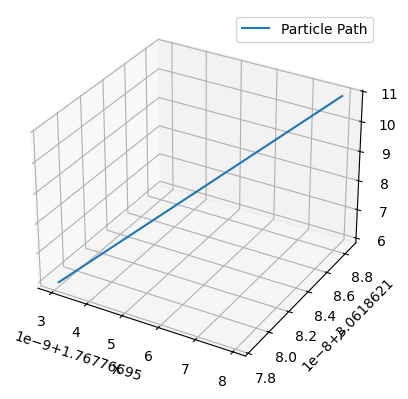

In [22]:
# Create a particle
particle = Particle(
    initial_r=5, initial_theta=np.pi/4, initial_phi=np.pi/3,
    initial_velocity={'x': 0.1, 'y': 0.2, 'z': 0.1}
)

# Generate path
timeline = np.linspace(0, T, 200)
x_path, y_path, z_path, t_path = particle.get_path(timeline)

# Plot the path
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_path, y_path, z_path, label='Particle Path')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.legend()
plt.show()